<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Guassian-Naive-Bayes" data-toc-modified-id="Guassian-Naive-Bayes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Guassian Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data generation</a></span></li><li><span><a href="#Look-inside" data-toc-modified-id="Look-inside-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Look inside</a></span></li><li><span><a href="#Accuracy" data-toc-modified-id="Accuracy-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Accuracy</a></span></li><li><span><a href="#Imbalanced-data" data-toc-modified-id="Imbalanced-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Imbalanced data</a></span></li></ul></li><li><span><a href="#Discrete-Naive-Bayes" data-toc-modified-id="Discrete-Naive-Bayes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Discrete Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Look-inside" data-toc-modified-id="Look-inside-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Look inside</a></span></li><li><span><a href="#Prediction-process" data-toc-modified-id="Prediction-process-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prediction process</a></span></li><li><span><a href="#Accuracy" data-toc-modified-id="Accuracy-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Accuracy</a></span></li><li><span><a href="#Multinominal-Naive-Bayes" data-toc-modified-id="Multinominal-Naive-Bayes-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Multinominal Naive Bayes</a></span></li><li><span><a href="#Download-data-to-disk" data-toc-modified-id="Download-data-to-disk-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Download data to disk</a></span></li><li><span><a href="#Load-data-from-disk" data-toc-modified-id="Load-data-from-disk-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Load data from disk</a></span></li><li><span><a href="#Regularize-data" data-toc-modified-id="Regularize-data-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Regularize data</a></span></li><li><span><a href="#Train-and-test" data-toc-modified-id="Train-and-test-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Train and test</a></span></li></ul></li></ul></div>

# Implementation

In [1]:
import numpy as np
import scipy.sparse as ss

#X[Ndata,Nfeature]=[
#   [(0 - Xlen[0]-1), (0 - Xlen[1]-1) ...]
#   [(0 - Xlen[0]-1), (0 - Xlen[1]-1) ...]
#   [(0 - Xlen[0]-1), (0 - Xlen[1]-1) ...]
#]
#
# y[Ndata]=[(0 - Nlabels-1), (0 - Nlabels-1) ... ]

# non-rereactagular array
# condition_prob[Nfeature,Nvalues of the feature, Nlabels] = list[
#  [Nvalues of the feature, Nlabels]
# ]
#
#priory_prob[Nlabels]
#
def NaiveBayes_train(X, Xlen, y, nlabels, alpha):

    #print(Xlen)
    #print(X)
    #print(y)
    
    priory_prob=np.zeros(nlabels)
    
    for i in range(nlabels):
        priory_prob[i] = np.sum(y==i) + alpha
        
    # normalization
    priory_prob /= np.sum(priory_prob)
        
    
    condition_prob=[np.zeros((l, nlabels)) for l in Xlen]
    
    for i in range(nlabels):
        
        Xi=X[y==i]
        for f in range(X.shape[1]):
            
            num=np.empty(Xlen[f])
            
            ## np.bincount?
            ## we just can't set minlength in numba
            ## so we use slow version in python
            
            for fv in range(Xlen[f]):
                num[fv] = np.sum(Xi[:,f]==fv) + alpha
                
            tot_num=np.sum(num)
            prob = num/tot_num
            #print(prob)
            #print(condition_prob[f][i])
            condition_prob[f][:,i]=prob
        
        
    return condition_prob, priory_prob
        
            

class NaiveBayes:
    
    def __init__(self, alpha=1):
        self.alpha=alpha
        pass

    def map_label(self,y):
        ydict=set(y)
        labels=list(ydict)
        labels.sort()
                
        labels_index={}
        for i,v in enumerate(labels):
            labels_index[v]=i
            
        yb=np.zeros(len(y), dtype=np.int_)        
        for i in range(len(y)):
            yb[i]=labels_index[y[i]]
        
        return yb,labels,labels_index
    
    
        
    def fit(self, X, y):
        assert X.ndim==2, X.shape
        assert y.ndim==1, y.shape
        assert X.shape[0] == y.shape[0]
        
        y,labels,labels_index=self.map_label(y)
        
        nfeature=X.shape[1]

        Xb=np.empty_like(X)
        featrue_values=[None]*nfeature
        feature_value_indices=[None]*nfeature
        for f in range(nfeature):
            X_f,features_f,features_index_f=self.map_label(X[:,f])
            Xb[:,f]=X_f
            featrue_values[f]=features_f
            feature_value_indices[f]=features_index_f
        X=Xb
        
        self.feature_value_indices=feature_value_indices
        self.featrue_values=featrue_values
        self.labels=labels
        self.labels_index=labels_index
        
        Xlen=np.array([len(vs) for vs in featrue_values])
        
        self.condition_prob, self.priory_prob=NaiveBayes_train(X, Xlen,
                        y, nlabels=len(labels), alpha=self.alpha)
        

    def info(self):
        print("%-8s"%"y", "priory probabilty")
        for lab,prob in zip(self.labels, self.priory_prob):
            print("%-8s"%str(lab), prob)

        nlabels=self.labels
        for f,(vs,prob) in enumerate(zip(self.featrue_values, self.condition_prob)):
            print("%-8s"%("X[%d]\y"%f), self.labels)
            for x,p in zip(vs, prob):
                print("%-+8.3f"%x, p)
            print("%-8s"%"sum", np.sum(prob,axis=0))

    def predict_process(self,x):
        print("%-15s"%"input", x)
        print("%-15s"%"index", [idx[x[f]] if x[f] in idx else -1 for f,idx in enumerate(self.feature_value_indices)])
        
        print("======================================")
        print("%-15s"%"y", self.labels)
        print("--------------------------------------")
        pp=np.ones(len(self.labels))
        for f, xf in enumerate(x):
            if xf in self.feature_value_indices[f]:
                idx= self.feature_value_indices[f][xf]
            else:
                idx=-1
            p=self.condition_prob[f][idx]
            print("%-15s"%("P(X[%d]|y)"%f), p)
            pp *= p
        print("%-15s"%("P(X[...]|y)"), pp)
            

        print("%-15s"%"priory prob", self.priory_prob)
        print("%-15s"%("P(X[...],y)"), pp*self.priory_prob)
        print("%-15s"%("P(X[...])"), np.sum(pp*self.priory_prob))
        print("%-15s"%("P(y|X[...])"), pp*self.priory_prob/np.sum(pp*self.priory_prob))
        print("======================================")
            
    def predict(self, X):

        featrue_values=self.featrue_values
        nfeature=len(featrue_values)
        nlabels=len(self.labels)
        feature_value_indices=self.feature_value_indices
        
        Xb=np.zeros(X.shape, dtype=np.int_)
        
        for i in range(X.shape[0]):
            for f in range(X.shape[1]):
                if X[i,f] in feature_value_indices[f]:                 
                    Xb[i,f]=feature_value_indices[f][X[i,f]]
                else:
                    # never see this value
                    # we don't use it
                    Xb[i,f]=-1
                    
        X=Xb
        
        # conditional marginal distribution
        condition_mag_prob=np.empty((nfeature,X.shape[0],nlabels))            
        for f in range(nfeature):
            # [nvalues,y]
            table=self.condition_prob[f]
            table=np.vstack(( table, np.ones((1,table.shape[1])) ))
            # remember X[i,f] is -1
            condition_mag_prob[f,:]=table[X[:,f]]
        #print(condition_mag_prob)

        # conditonal distribution
        condition_prob=np.zeros((X.shape[0],nlabels))
        for cp in condition_mag_prob:
            condition_prob += np.log(cp)
        condition_prob=np.exp(condition_prob)
        #print(condition_prob)
        
        prob = condition_prob * self.priory_prob.reshape(-1,nlabels)
        prob = prob/prob.sum(axis=-1).reshape(-1,1)
        idx = np.argmax(prob,axis=-1)
        
        yhat=np.empty(X.shape[0],dtype=np.int_)
        for i_data,label_idex in enumerate(idx):
            yhat[i_data] = self.labels[label_idex]
            
        
        return yhat

                
class GaussianNB:
    '''
    Gaussian Naive Bayes
    '''
    
    
    def __init__(self, alpha=1):
        self.alpha=alpha
        
    def fit(self, X, y):
        '''
        X = ndarray[<numerical type>, ndim=2]        
        y = ndarray[<int type>, ndim=1]
        y start from 0 to nlabels-1
        '''
        assert X.ndim == 2, X.shape
        assert y.ndim == 1, y.shape
        assert X.shape[0] == y.shape[0]
        
        alpha = self.alpha
        nlabels = np.max(y)+1
        nfeatures = X.shape[1]
        
        
        
        
        priory_prob = np.zeros(nlabels)
        rms=np.zeros((X.shape[1], nlabels))
        mean=np.zeros((X.shape[1], nlabels))
        
        for label in range(nlabels):
            exm = X[y==label]
            # moments estimation
            rms[:,label] = exm.std(axis=0)
            mean[:,label] = exm.mean(axis=0)
            priory_prob[label] = (np.sum(y==label) + alpha)/(y.shape[0] + alpha * nlabels)
            
            
            
        self.sigma = rms
        self.mean = mean
        self.nlabels = nlabels
        self.nfeatures = nfeatures
        self.priory_prob = priory_prob
            
    def info(self):
        '''
        print fit info
        '''
        priory_prob = self.priory_prob
        sigma = self.sigma
        mean = self.mean        
        nlabels = self.nlabels
        nfeatures = self.nfeatures
        
        print("%-8s"%"label", "priory probabilty")
        for lab,prob in enumerate(priory_prob):
            print("%-8s"%lab, prob)

        
        for l in range(nlabels):
            print("%8s,%8s: mean +- sigma"%("label","feature"))
            for f in range(nfeatures):
                print("%8d,%8d: %+0.3f +- %+0.3f"%(l, f, mean[f,l], sigma[f,l]))

        
    def predict(self, X):
        '''
        X = ndarray[<numerical type>, ndim=2]        
        y = ndarray[<int type>, ndim=1]
        y start from 0 to nlabels-1
        '''
        sigma = self.sigma
        mean = self.mean
        priory_prob = self.priory_prob

        dx = X[:,:,np.newaxis] - mean
        
        logp = -0.5 * dx * dx / (sigma*sigma)
        logp = np.sum(logp, axis=-2) + np.log(priory_prob)
        
        yhat = np.argmax(logp, axis=-1)
        return yhat
    
    
class MultinomialNB:
    '''
    Multinomial Naive Bayes
    '''
    
    def __init__(self, alpha=1):
        self.alpha=alpha
        
        
    def fit(self, X, y):
        '''
        X = sparse[<numerical type>, ndim=2]        
        y = ndarray[<int type>, ndim=1]
        y start from 0 to nlabels-1
        '''
        assert X.ndim == 2, X.shape
        assert y.ndim == 1, y.shape
        assert X.shape[0] == y.shape[0]
        
        alpha = self.alpha
        nlabels = np.max(y)+1
        nfeatures = X.shape[1]
        
        
        
        
        priory_prob = np.zeros(nlabels)
        condition_prob = np.zeros((nlabels, nfeatures))
        
        for label in range(nlabels):
            priory_prob[label] = (np.sum(y==label) + alpha)/(y.shape[0] + alpha * nlabels)
            
        csr_X = ss.csr_matrix(X)
        for label in range(nlabels):
            Xi = csr_X[y == label];
            ni = Xi.sum(axis=0)
            condition_prob[label,:] = (ni + alpha)/(ni.sum() + nfeatures*alpha)
            
            
        self.nlabels = nlabels
        self.nfeatures = nfeatures
        self.priory_prob = priory_prob
        self.condition_prob = condition_prob

    def info(self):
        print(self.priory_prob)
        print(self.condition_prob)
        
    def predict(self, X):
        '''
        X = sparse[<numerical type>, ndim=2]        
        y = ndarray[<int type>, ndim=1]
        y start from 0 to nlabels-1
        '''
        priory_prob = self.priory_prob
        condition_prob = self.condition_prob
        
        csr_X = ss.csr_matrix(X)
        logp = csr_X.dot(np.log(condition_prob).T) + np.log(priory_prob)        
        
        yhat = np.argmax(logp, axis=-1)
        return yhat
    

# Guassian Naive Bayes

## Data generation

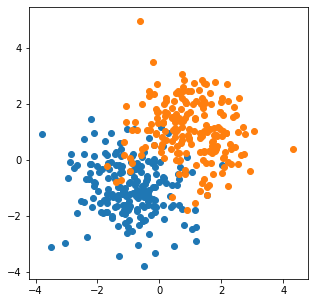

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def gen_data(center,n=200,random_state=1):
    rnd=np.random.RandomState(random_state)

    if isinstance(n, int):        
        Xs=[rnd.randn(n,2) + c for c in center]
        ys=[np.full(n, i) for i in range(len(center))]
    else:
        assert len(n) == len(center), n
        Xs=[rnd.randn(n_,2) + c for c,n_ in zip(center,n)]
        ys=[np.full(n_, i) for i,n_ in enumerate(n)]
        
    X=np.vstack(Xs)
    y=np.hstack(ys)
    pert=np.random.permutation(X.shape[0])
    X=X[pert]
    y=y[pert]
    
    return X,y

def plot_data(X, y):
    plt.figure(figsize=(5,5))
    nlabels=int(np.amax(y)+1)
    for i in range(nlabels):
        plt.scatter(X[y==i,0], X[y==i,1])
        
    plt.show()

X,y=gen_data([[-1,-1],[1,1]])
plot_data(X, y)

accuracy: 0.925


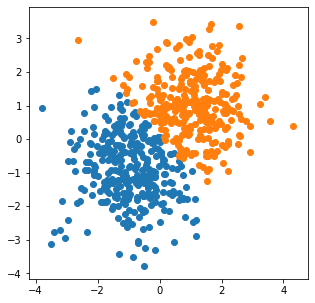

In [3]:
np.random.seed(0)
X,y=gen_data([[-1,-1],[1,1]],300)

gnb=GaussianNB()
gnb.fit(X, y)

yhat=gnb.predict(X)
print("accuracy:",np.sum(yhat==y)/y.shape[0])
plot_data(X, yhat)

## Look inside

In [4]:
gnb.info()

label    priory probabilty
0        0.5
1        0.5
   label, feature: mean +- sigma
       0,       0: -0.944 +- +0.975
       0,       1: -0.925 +- +1.020
   label, feature: mean +- sigma
       1,       0: +0.976 +- +1.006
       1,       1: +0.994 +- +0.933


## Accuracy

accuracy: 0.9325


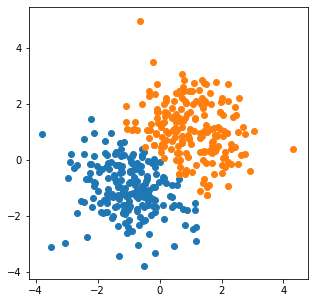

In [5]:
np.random.seed(0)

X,y=gen_data([[-1,-1],[1,1]],n=200)
gnb=GaussianNB()
gnb.fit(X, y)

X,y=gen_data([[-1,-1],[1,1]],n=200)
yhat=gnb.predict(X) 

print("accuracy:",np.sum(yhat==y)/y.shape[0])
plot_data(X, yhat)

## Imbalanced data

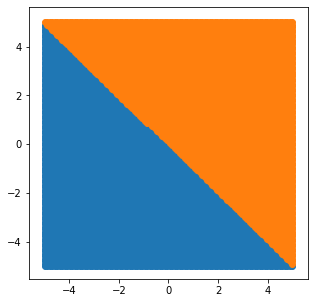

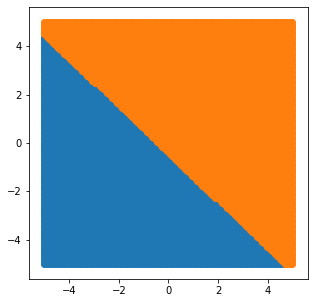

In [6]:
np.random.seed(0)
X,y=gen_data([[-1,-1],[1,1]],n=(2000,2000))
gnb1=GaussianNB(alpha=1)
gnb1.fit(X, y)

X,y=gen_data([[-1,-1],[1,1]],n=(2000,5000))
gnb2=GaussianNB(alpha=1)
gnb2.fit(X, y)


xx,yy=np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
X=np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))

yhat=gnb1.predict(X) 
plot_data(X, yhat)

yhat=gnb2.predict(X)
plot_data(X, yhat)

# Discrete Naive Bayes

## Look inside

In [7]:
np.random.seed(0)
X,y=gen_data([[-1,-1],[1,1]],300)
Xdsc=np.floor_divide(X,0.4)*0.4

nbs=NaiveBayes()
nbs.fit(Xdsc, y)

nbs.info()

y        priory probabilty
0        0.5
1        0.5
X[0]\y   [0, 1]
-4.000   [0.00625  0.003125]
-3.600   [0.0125   0.003125]
-3.200   [0.021875 0.003125]
-2.800   [0.040625 0.003125]
-2.400   [0.065625 0.00625 ]
-2.000   [0.090625 0.009375]
-1.600   [0.153125 0.0125  ]
-1.200   [0.1625 0.0375]
-0.800   [0.1375 0.0375]
-0.400   [0.125    0.065625]
+0.000   [0.075    0.103125]
+0.400   [0.05     0.121875]
+0.800   [0.03125  0.159375]
+1.200   [0.00625  0.178125]
+1.600   [0.003125 0.1     ]
+2.000   [0.00625 0.08125]
+2.400   [0.003125 0.04375 ]
+2.800   [0.003125 0.0125  ]
+3.200   [0.003125 0.0125  ]
+4.000   [0.003125 0.00625 ]
sum      [1. 1.]
X[1]\y   [0, 1]
-4.000   [0.00626959 0.0031348 ]
-3.600   [0.01567398 0.0031348 ]
-3.200   [0.02194357 0.0031348 ]
-2.800   [0.03761755 0.0031348 ]
-2.400   [0.05329154 0.0031348 ]
-2.000   [0.14106583 0.00626959]
-1.600   [0.11912226 0.01253918]
-1.200   [0.15360502 0.01567398]
-0.800   [0.12852665 0.04388715]
-0.400   [0.11598746 0.06583072

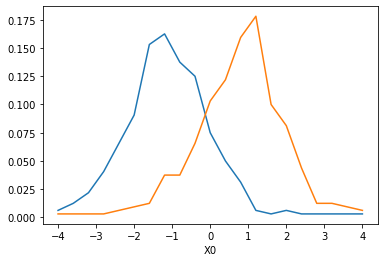

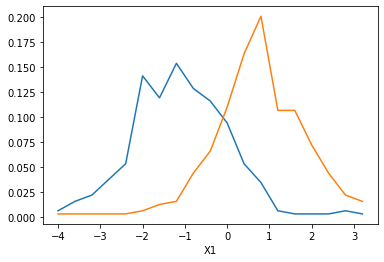

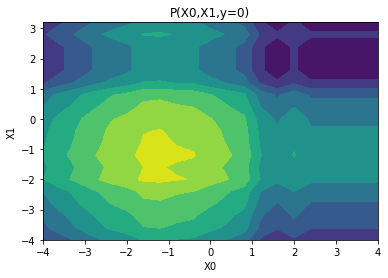

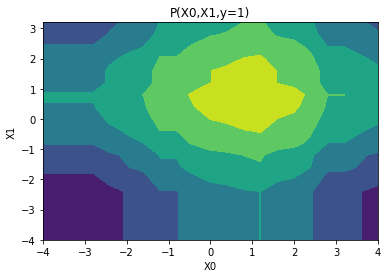

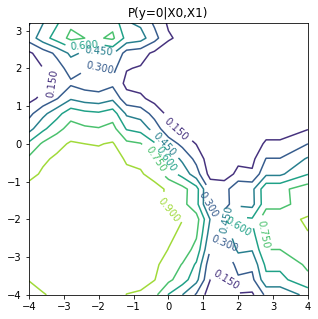

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

plt.figure()
x0=nbs.featrue_values[0]
x1=nbs.featrue_values[1]
p0_x0=nbs.condition_prob[0][:,0]
p0_x1=nbs.condition_prob[1][:,0]
p1_x0=nbs.condition_prob[0][:,1]
p1_x1=nbs.condition_prob[1][:,1]

plt.plot(x0,p0_x0,label="label=0")
plt.plot(x0,p1_x0,label="label=1")
plt.xlabel("X0")
plt.show()

plt.figure()
plt.plot(x1,p0_x1,label="label=0")
plt.plot(x1,p1_x1,label="label=1")
plt.xlabel("X1")
plt.show()

zz0=p0_x1.reshape(-1,1).dot(p0_x0.reshape(1,-1))
zz1=p1_x1.reshape(-1,1).dot(p1_x0.reshape(1,-1))
xx,yy=np.meshgrid(x0, x1)

plt.figure()
plt.contourf(xx,yy,np.log(zz0))
plt.ylabel("X1")
plt.xlabel("X0")
plt.title("P(X0,X1,y=0)")
plt.show()

plt.figure()
plt.contourf(xx,yy,np.log(zz1))
plt.ylabel("X1")
plt.xlabel("X0")
plt.title("P(X0,X1,y=1)")
plt.show()

plt.figure(figsize=(5,5))
c=plt.contour(xx,yy,zz0/(zz0+zz1))
plt.title("P(y=0|X0,X1)")
plt.clabel(c,fontsize=10)
plt.show()

##  Prediction process

In [9]:
nbs.predict_process(Xdsc[0])

input           [1.2 0.8]
index           [13, 12]
y               [0, 1]
--------------------------------------
P(X[0]|y)       [0.00625  0.178125]
P(X[1]|y)       [0.03448276 0.20062696]
P(X[...]|y)     [0.00021552 0.03573668]
priory prob     [0.5 0.5]
P(X[...],y)     [0.00010776 0.01786834]
P(X[...])       0.017976097178683384
P(y|X[...])     [0.00599455 0.99400545]


## Accuracy

accuracy: 0.9275


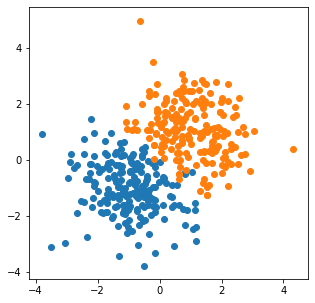

In [10]:
np.random.seed(0)

X,y=gen_data([[-1,-1],[1,1]],n=200)
Xdsc=np.floor_divide(X,0.4)*0.4
nbs=NaiveBayes(alpha=0.01)
nbs.fit(Xdsc, y)

X,y=gen_data([[-1,-1],[1,1]],n=200)
Xdsc=np.floor_divide(X,0.4)*0.4
yhat=nbs.predict(Xdsc) 

print("accuracy:",np.sum(yhat==y)/y.shape[0])
plot_data(X, yhat)

## Multinominal Naive Bayes

## Download data to disk

In [11]:
def download_chinese_name():
    import urllib.request
    url = "https://raw.githubusercontent.com/lhprojects/Chinese-Names-Corpus/master/Chinese_Names_Corpus/Chinese_Names_Corpus_Gender%EF%BC%88120W%EF%BC%89.txt"
    urllib.request.urlretrieve(url, "chinese_names.txt")

# donwload using urllib.request
# download_chinese_name()
# or you can use wget 
# !wget "https://raw.githubusercontent.com/lhprojects/Chinese-Names-Corpus/master/Chinese_Names_Corpus/Chinese_Names_Corpus_Gender%EF%BC%88120W%EF%BC%89.txt"  -O "chinese_names.txt"
# or you can use a browser, like chrome. save and rename it to "chinese_names.txt"

## Load data from disk

In [12]:
def read_chinese_name_file():
    global data_names
    global data_genders
    data_names = []
    data_genders = []
    with open("chinese_names.txt", encoding='utf-8') as f:
        ln = 0
        while True:
            line = f.readline()  # there is no empty line util the end of file
            if not line:
                break
            if ln >= 4:
                name, sex = line.split(',')
                data_names.append(name)
                data_genders.append(sex.strip())

            ln += 1
    data_names=np.array(data_names)
    data_genders=np.array(data_genders)
    print("%d examples in total"%len(data_names))
    print("First ten exmaples:")
    print(data_names[:10])
    print(data_genders[:10])

read_chinese_name_file()

1163760 examples in total
First ten exmaples:
['阿安' '阿奥' '阿贝贝' '阿彬' '阿彬彬' '阿斌' '阿斌斌' '阿滨' '阿冰' '阿冰冰']
['男' '未知' '女' '未知' '男' '男' '男' '男' '女' '女']


## Regularize data

In [13]:
import itertools


def regularize_data():
    global data_names
    global data_genders
    global coo_X
    global csr_X
    global y

    
    np.random.seed(0)

    # gender
    genders = ["男", "女"]
    genders_indices = {"男": 0, "女": 1}
    print("Genders mapping:")
    print(genders_indices)

    #chars
    chars = set()
    for name in data_names:
        chars.update(name)

    chars = list(chars)
    chars.sort()
    chars_indices = {}
    for i, c in enumerate(chars):
        chars_indices[c] = i

    print("Character mapping:")
    print([(k, v) for k, v in itertools.islice(chars_indices.items(), 10)])

    
    # X
    print("Data shuffled")
    pert = np.random.permutation(len(data_names))
    names_sort = data_names[pert]
    gender_sort = data_genders[pert]


    rows = []
    cols = []
    vals = []
    y_list=[]

    row=0
    for idata, name in enumerate(names_sort):

        if gender_sort[idata] == "未知": # unkown
            continue
        
        y_list.append(genders_indices[gender_sort[idata]])
        for ichar, char in enumerate(name):

            if len(name) > 0 and ichar == 0:
                continue

            idx = chars_indices[char]
            rows.append(row)
            cols.append(idx)
            vals.append(1)
        row += 1

    coo_X = ss.coo_matrix((vals, (rows, cols)),
                      shape=(len(y_list), len(chars)))
    csr_X = ss.csr_matrix(coo_X)

    print("First five names:")
    print(names_sort[:5])
    print("First five name sencoded:")
    for i in range(5):
        print([(i,v) for i,v in zip(csr_X[i].indices, csr_X[i].data)])
        print([(i,chars[i]) for i in csr_X[i].indices])
        
    # y
    y = np.array(y_list)
    print("First five genders encoded:")
    print(y[:5])


regularize_data()

Genders mapping:
{'男': 0, '女': 1}
Character mapping:
[('一', 0), ('丁', 1), ('七', 2), ('万', 3), ('三', 4), ('上', 5), ('不', 6), ('与', 7), ('专', 8), ('丕', 9)]
Data shuffled
First five names:
['宋国奇' '梁平平' '沈宪平' '高佳佳' '龙成志']
First five name sencoded:
[(355, 1), (434, 1)]
[(355, '国'), (434, '奇')]
[(646, 2)]
[(646, '平')]
[(533, 1), (646, 1)]
[(533, '宪'), (646, '平')]
[(117, 2)]
[(117, '佳')]
[(725, 1), (778, 1)]
[(725, '志'), (778, '成')]
First five genders encoded:
[0 0 0 1 0]


## Train and test

In [14]:
def train():
    
    Ndata = csr_X.shape[0]//2
    X_train = csr_X[:Ndata]
    X_test = csr_X[Ndata:]
    y_train = y[:Ndata]
    y_test = y[Ndata:]

    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    
    print("Training accuracy:")
    yhat = mnb.predict(X_train)
    print(np.sum(yhat == y_train) / yhat.shape[0])
    
    print("Testing accuracy:")
    yhat = mnb.predict(X_test)
    print(np.sum(yhat == y_test) / yhat.shape[0])


train()

Training accuracy:
0.9833136048053817
Testing accuracy:
0.9825557291832765
